In [226]:
from l1_csvd.metrics import metric_11, join_sol, Mp, Mah_dist, NR, R_sv, rate_to_db
from l1_csvd.utils.seed import seed_everything
from scipy.stats import loguniform
from joblib import Parallel, delayed

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from tqdm.notebook import tqdm
from IPython.display import display
from copy import deepcopy
import warnings

warnings.filterwarnings('ignore')
sns.set()

%matplotlib inline
%load_ext autoreload
%autoreload 2

seed_everything(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import numpy as np
from scipy.stats import ortho_group

from l1_csvd.utils import L1pca

def L1_cSVD(X, K, Sigma_clean=None, seed=42, num_iter=100):
    """Get L1 cSVD decomposition.

    Parameters
    ----------
    X:
        data matrix
    K:
        the number of components
    num_iter:
        number of iterations
    """
    
    seed_everything(seed)
    D, N = X.shape
    U = L1pca(X, K)
    A = np.dot(X.T, U)
    Sigma = np.zeros((K, K))
    V = ortho_group.rvs(dim=N, random_state=seed)[:K].T
    
    metrics = {
        "Mp": [],
        "metric_11": [],
        "join_sol": [],
        "Mah_dist": [],
        "NR": [],
        "R_sv": []
    }
    
    for _ in tqdm(range(num_iter)):
        for i in range(K):
            s = np.empty(N)
            M = np.empty(N)
            for j in range(N):
                s[j] = A[j][i] / V[j][i]

                tmp = A[:, i] - s[j] * V[:, i]
                M[j] = np.linalg.norm(tmp, ord=1)

            j_opt = np.argmin(M)
            Sigma[i][i] = s[j_opt]
        tmp = np.diag(1 / np.diagonal(Sigma))
        U_, Sigma_, V_ = np.linalg.svd(np.dot(A, tmp), full_matrices=False)
        V = np.dot(U_, V_)
        
        metrics["metric_11"].append(metric_11(X, U, Sigma, V))
        metrics["Mp"].append(Mp(X, U, Sigma, V))
        if Sigma_clean is not None:
            metrics["R_sv"].append(R_sv(Sigma, Sigma_clean))
                
    return U, Sigma, V, metrics


## A. Algorithm Analysis: Convergence

In [3]:
X = np.random.randn(10, 50)

In [ ]:
all_metrics = []
seeds = np.arange(4)

for s in seeds:
    _, _, _, metrics = L1_cSVD(X, K=4, seed=s, num_iter=6)
    all_metrics.append(metrics)

In [5]:
all_metrics = [{k: v for k, v in x.items() if v} for x in all_metrics]
names = list(all_metrics[0].keys())

res = pd.DataFrame(columns=names + ["seed", "iter"])
for ii, seed in enumerate(seeds):
    for i in range(len(all_metrics[0][names[0]])):
        rr = []
        for name in names:
            rr.append(all_metrics[ii][name][i])
        
        rr.extend([seed, i+1])
        res.loc[len(res) + 1] = rr

for c in res.columns:
    if c not in names:
        res[c] = res[c].astype(int)

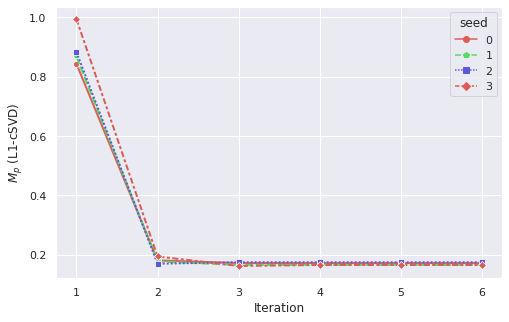

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data=res, x="iter", y="Mp", hue="seed", style="seed", markers=["o", "p", "s", "D"], linewidth=2,
             palette="hls", ax=ax)
plt.ylabel(r'$M_p$ (L1-cSVD)')
plt.xlabel(r'Iteration')
plt.savefig("./images/conv.pdf", bbox_inches="tight", format="pdf")
plt.show()

## B. Performance Analysis with Synthetic Dataset

In [ ]:
def get_noise(n, s, snr_db):
    snr = 1 / 10.0**(snr_db/10.0)
    es = (s ** 2).sum()
    en = (n ** 2).sum()
    
    alpha = np.sqrt(es / (snr * en))
    return alpha * n

def get_osr_noise_exact(G, R_out, S_out, S, osr_db):
    osr = 10.0**(osr_db/10.0)
    
    fl = True
    while fl:
        n = np.random.randn(*S_out.shape)
        A = G * (R_out @ S_out)
        B = G * (R_out @ n)
        
        a = (B ** 2).sum()
        b = 2 * (A * B).sum()
        c = (A ** 2).sum() - (S ** 2).sum() / osr

        rt = np.roots([a, b, c])
        if not(len(rt) == 0 or rt[0].imag != 0):
            fl = False
    return S_out + n * rt[0]

def get_osr_noise_pytorch(G, R_out, S_out, S, osr_db):
    osr = 10.0**(osr_db/10.0)
    
    class Net(nn.Module):
        def __init__(self, n, G, R_out, S_out, S0, osr_db):
            super().__init__()
            self.n = torch.nn.Parameter(n, requires_grad=True)
            self.G = torch.nn.Parameter(G, requires_grad=False)
            self.R_out = torch.nn.Parameter(R_out, requires_grad=False)
            self.S_out = torch.nn.Parameter(S_out, requires_grad=False)
            self.osr_db = torch.nn.Parameter(torch.Tensor([osr_db]), requires_grad=False)
            self.signal_norm = torch.nn.Parameter(torch.Tensor([(S0 ** 2).sum()]), requires_grad=False)
            self.S0 = torch.nn.Parameter(torch.Tensor(S0), requires_grad=False)
            
        def forward(self, x):
            return 10 * torch.log10(NR(self.G * (self.R_out @ (self.S_out + self.n)), self.S0))
 
    n = torch.randn(*S_out.shape)
    G = torch.Tensor(G)
    R_out = torch.Tensor(R_out)
    S_out = torch.Tensor(S_out)
    S = torch.Tensor(S)
    model = Net(n, G, R_out, S_out, S0, osr_db)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    best_l = 1e6
    best_n = model.n.data
    for i in range(10000):
        optimizer.zero_grad()
        outputs = model(torch.tensor([]))
        # loss = criterion(outputs, torch.log(torch.Tensor([model.signal_norm])) - torch.log(torch.Tensor([osr])))
        loss = criterion(outputs, torch.Tensor([osr_db]))
        
        if loss < best_l:
            best_l = loss
            best_n = deepcopy(model.n.data)
        loss.backward()
        optimizer.step()
    
    return (model.S_out.data + best_n).numpy()


D = 10
N = 50
K = 4
K_0 = 4
P_0 = 0.04

SNR_db = 10
OSR_db = 10

U0 = np.random.randn(D, K)
S0 = np.diag(np.sort(loguniform.rvs(1e-3, 1e1, size=K))[::-1])
V0 = np.random.randn(N, K)

N_matr = np.random.randn(D, N)
N_matr = get_noise(N_matr, S0, SNR_db)

R_out = np.random.randn(D, K_0)
G = np.random.choice([0, 1], p=[1 - P_0, P_0], size=N)
G = np.tile(G.reshape(1, -1), (D, 1))
S_out = np.random.randn(K_0, N)
S_out = get_osr_noise_pytorch(G, R_out, S_out, S0, OSR_db)

O_matr = G * (R_out @ S_out)

X_clean = U0 @ S0 @ V0.T
X_corrupted = X_clean + N_matr + O_matr

##### Check that matrix with cetrain SNR were founded right 

In [ ]:
SNR_db, rate_to_db(NR(N_matr, S0))

(10, 10.0)

In [ ]:
OSR_db, rate_to_db(NR(O_matr, S0))

(10, 9.999998390214667)

In [ ]:
N_points = 10 ** 2
step = 5
# SNR_grid = np.arange(-20, 21, step).tolist()
SNR_grid = [10]

# OSR_grid = np.arange(-20, 21, step).tolist()
OSR_grid = np.random.uniform(-20, 20, N_points).tolist()

In [ ]:
add_cols = [f"R_sv_{i+1}" for i in range(K)]
res = pd.DataFrame(columns=["R_sv", "SNR (db)", "OSR (db)", "method"] + add_cols)

for SNR_db in SNR_grid:
    for OSR_db in OSR_grid:
        S_out = np.random.randn(K_0, N)
        N_matr = get_noise(N_matr, S0, SNR_db)
        S_out = get_osr_noise_pytorch(G, R_out, S_out, S0, OSR_db)
        O_matr = G * (R_out @ S_out)

        X_corrupted = X_clean + N_matr + O_matr
        
        metrics = []
        _, S_est, _, metrics = L1_cSVD(X_corrupted, K, Sigma_clean=S0, seed=42)
        res.loc[len(res) + 1] = [metrics["R_sv"][-1], SNR_db, OSR_db, "L1-cSVD"] + np.diag(S_est).tolist()
        
        vanilla_s = np.linalg.svd(X_corrupted, full_matrices=False)
        vanilla_s = np.diag(vanilla_s[1][:K])
        res.loc[len(res) + 1] = [R_sv(vanilla_s, S0), SNR_db, OSR_db, "SVD"] + np.diag(vanilla_s).tolist()

for i, c in enumerate(add_cols):
    res[c] = ((res[c] - S0[i, i]) ** 2) / (S0[i, i] ** 2)

scols = ["R_sv"] + add_cols

all_res = []
x_new = np.linspace(-20, 20, res[res.method == "SVD"].shape[0])
for m in res.method.unique():
    v = res[res.method == m].sort_values("OSR (db)").copy()
    for c in scols:
        vv = v["OSR (db)"].values
        v["OSR (db)"] = x_new
        model = np.poly1d(np.polyfit(vv, v[c].values, 10))
        v[c] = model(x_new)
    all_res.append(v)

sm_res = pd.concat(all_res, axis=0)
res = sm_res

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

$\operatorname{OSR}(X) = \frac{\|X\|_F^2}{\|S_{true}\|_F^2}$

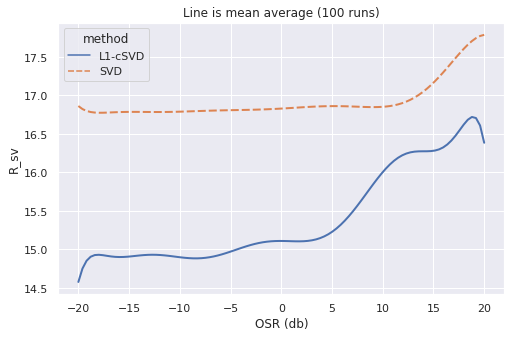

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data=res, x="OSR (db)", y="R_sv", hue="method", style="method", linewidth=2,
             ax=ax)
plt.title('Line is mean average ({} runs)'.format(N_points))
plt.savefig("./images/exp_B_r_sv_v2.pdf", bbox_inches="tight", format="pdf")
plt.show()

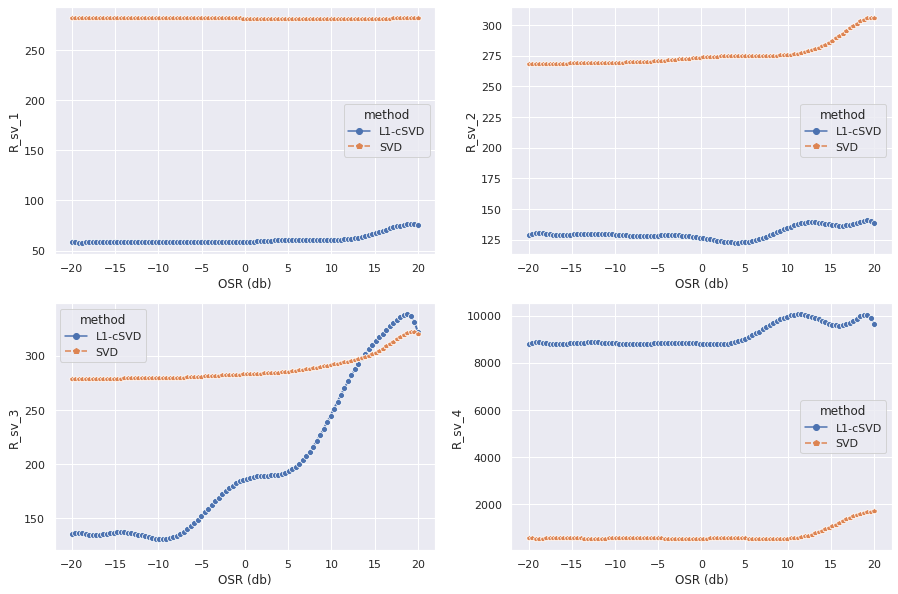

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axs = np.array(axs).flatten()

for i, ax in enumerate(axs):
    sns.lineplot(data=res, x="OSR (db)", y=f"R_sv_{i+1}", hue="method", style="method", markers=["o", "p"], linewidth=2,
             ax=ax)
plt.savefig("./images/exp_B_r_sv_i.pdf", bbox_inches="tight", format="pdf")
plt.show()

## C. Bayesian Classifier

In [229]:
import pmlb
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [230]:
vowel_data = pmlb.fetch_data('vowel')
vowel_data

,Train or Test,Speaker Number,Sex,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,target
0,1,0,1,-3.639,0.418,-0.670,1.779,-0.168,1.627,-0.388,0.529,-0.874,-0.814,8
1,1,0,1,-3.327,0.496,-0.694,1.365,-0.265,1.933,-0.363,0.510,-0.621,-0.488,2
2,1,0,1,-2.120,0.894,-1.576,0.147,-0.707,1.559,-0.579,0.676,-0.809,-0.049,1
3,1,0,1,-2.287,1.809,-1.498,1.012,-1.053,1.060,-0.567,0.235,-0.091,-0.795,0
4,1,0,1,-2.598,1.938,-0.846,1.062,-1.633,0.764,0.394,-0.150,0.277,-0.396,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,0,14,0,-3.239,3.083,-1.427,-0.202,-0.282,1.421,0.576,0.068,-0.914,0.147,3
986,0,14,0,-3.753,3.605,-0.899,-0.747,-0.401,1.765,0.620,0.754,-0.835,-0.301,9
987,0,14,0,-3.980,2.459,0.068,0.023,0.237,1.029,-0.189,0.521,-0.773,-0.500,4
988,0,14,0,-4.264,2.925,0.065,0.794,0.323,0.515,-1.282,-0.140,-0.863,-0.390,10


In [231]:
vowel_data.columns

Index(['Train or Test', 'Speaker Number', 'Sex', 'Feature 0', 'Feature 1',
       'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5', 'Feature 6',
       'Feature 7', 'Feature 8', 'Feature 9', 'target'],
      dtype='object')

### Train test split

In [232]:
target = vowel_data["target"]
vowel_data_dropped = vowel_data.drop(columns=['Train or Test', 'Speaker Number'])
vowel_data_train, vowel_data_test = train_test_split(vowel_data_dropped,
                                                     test_size=1/6, stratify=target)
vowel_data_train.target.value_counts()

2     75
1     75
8     75
10    75
9     75
5     75
4     75
3     75
6     75
0     75
7     75
Name: target, dtype: int64

In [348]:
class BayesianClassifier:
    def __init__(self, use_l1csvd=False):
        self.medians = []
        self.Vs = []
        self.Ss = []
        self.use_l1csvd = use_l1csvd
    
    def make_outliers(self, X_i, power=25, outlier_num=3):
        mean = np.mean(X_i, axis=0)
        indices = np.random.choice(np.arange(X_i.shape[0]), replace=False, size=outlier_num)
        for ind in indices:
            rand_power = 2 * np.random.rand() - 1
            X_i[ind] += rand_power * power * mean
        return X_i
    
    def fit(self, vowel_data, with_outliers=False):
        self.medians = []
        self.Vs = []
        self.Ss = []
        
        for target in range(11):
            X_i = vowel_data[vowel_data_train['target'] == target].drop(columns=['target', 'Sex']).values
            if with_outliers:
                X_i = self.make_outliers(X_i)
            m_i = np.median(X_i, axis=0)
            self.medians.append(m_i)
            if self.use_l1csvd:
                U, S, VT, _ = L1_cSVD(X_i, K=10, seed=42, num_iter=10000)
                S = np.diag(S)
            else:
                U, S, VT = np.linalg.svd(X_i, full_matrices=False)
            self.Vs.append(VT.T)
            self.Ss.append(S)
    
    def predict_one(self, y):
        min_d = np.inf
        ans = None

        for i in range(len(self.medians)):
            d = 0

            m_i = self.medians[i]
            V = self.Vs[i]
            S = self.Ss[i]


            for j in range(m_i.size):
                sqrt_sum = np.sum(V[:, j] * (y - m_i)) / (S[j] / np.sqrt(990))
                d += sqrt_sum * sqrt_sum

            d = np.sqrt(d)
            if d <= min_d:
                min_d = d
                ans = i

        return ans
    
    def predict(self, vowel_data):
        pred = []

        for i, row in vowel_data.drop(columns=['target', 'Sex']).iterrows():
            ans = self.predict_one(row.values)
            pred.append(ans)
        
        return pred

In [347]:
svd_corrupted = []

for _ in tqdm(range(1000), leave=False):
    bclf = BayesianClassifier()
    bclf.fit(vowel_data_train, with_outliers=True)
    pred = bclf.predict(vowel_data_test)
    acc = accuracy_score(vowel_data_test["target"], pred)
    svd_corrupted.append(acc)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [350]:
l1csvd_corrupted = []

for _ in tqdm(range(1000), leave=False):
    bclf = BayesianClassifier(use_l1csvd=True)
    bclf.fit(vowel_data_train, with_outliers=True)
    pred = bclf.predict(vowel_data_test)
    acc = accuracy_score(vowel_data_test["target"], pred)
    l1csvd_corrupted.append(acc)

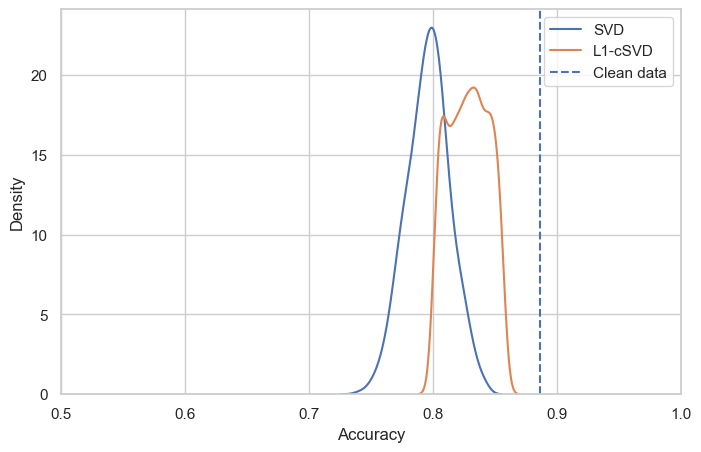

In [352]:
plt.figure(figsize = (8, 5))

bclf = BayesianClassifier()
bclf.fit(vowel_data_train)
pred = bclf.predict(vowel_data_test)
base_acc = accuracy_score(vowel_data_test["target"], pred)

sns.set_style('whitegrid')
sns.kdeplot(np.array(svd_corrupted), label="SVD")
sns.kdeplot(np.array(l1csvd_corrupted), label="L1-cSVD")
plt.axvline(x=base_acc, label="Clean data", linestyle='dashed')
plt.ylabel("Density")
plt.xlabel("Accuracy")
plt.xlim(0.5, 1)
plt.legend()
plt.show()